In [1]:
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from scipy import stats
from scipy.stats import norm
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from ddot import Ontology

In [2]:
plt.rcParams['svg.fonttype'] = 'none'

V_SMALL_SIZE = 8
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=V_SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [52]:
def create_scatter_plot_genes(X, Y, x_title, y_title):
    
    scatter_df = pd.DataFrame({x_title: X, y_title: Y})
    
    fig, ax = plt.subplots(figsize=(6,6))
    sns.scatterplot(data=scatter_df, x=x_title, y=y_title, s=35, ax=ax)
    
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()])  # max of both axes
        #-0.3, 1.0
    ]
    plt.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    return fig

In [4]:
def create_scatter_plot_systems(X, Y, H, x_title, y_title):
    
    scatter_df = pd.DataFrame({x_title: X, y_title: Y, 'hue': H})
    
    fig, ax = plt.subplots(figsize=(6,6))
    sns.scatterplot(data=scatter_df, x=x_title, y=y_title, hue='hue', s=35, ax=ax)
    
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    lims = [
        #np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        #np.max([ax.get_xlim(), ax.get_ylim()])  # max of both axes
        -0.3, 1.0
    ]
    plt.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    return fig

In [5]:
def create_histogram(data, x_title, y_title, h_range, fraction):
    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    
    data_size = len(data)
    class_size = int(data_size * fraction)
    x_sens = data[class_size - 1]
    x_resist = data[data_size - class_size]
    
    plt.hist(x=[data[i] for i in range(class_size)], bins=9, rwidth=0.85)
    plt.hist(x=[data[i] for i in range(data_size - class_size, data_size)], bins=9, rwidth=0.85)
    plt.hist(x=[data[i] for i in range(class_size, data_size - class_size)], bins=2, color='darkgrey', rwidth=0.85)
    
    mu, std = norm.fit(data)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    
    plt.axvline(x_sens, linewidth=2, color='black')
    plt.axvline(x_resist, linewidth=2, color='black')
    
    ax.grid(False)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    plt.show()
    return fig

In [6]:
def create_line_curve(X, Y, x_title, y_title, x_lim, y_lim):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    ax.plot(X, Y)
    ax.grid(False)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    plt.show()
    return fig

In [7]:
def create_kaplan_meier(T1, T2, E1, E2, entity):
    
    fig, ax = plt.subplots(figsize=(5, 5))
    kmf_d = KaplanMeierFitter()
    
    kmf_d = kmf_d.fit(T1, event_observed=E1, label='Sensitive (n = ' + str(len(T1)) + ')')
    kmf_d.plot(ci_show=False, ax=ax, show_censors=True)
    print('Median Survival (Sensitive): {:.1f}'.format(kmf_d.median_survival_time_))
    
    kmf_d = kmf_d.fit(T2, event_observed=E2, label='Resistant (n = ' + str(len(T2)) + ')')
    kmf_d.plot(ci_show=False, ax=ax, show_censors=True)
    print('Median Survival (Resistant): {:.1f}'.format(kmf_d.median_survival_time_))
    
    ax.set_xlim(0, 120)
    ax.set_ylim(0.0, 1.1)
    ax.set_xlabel('Overall Survival Months')
    ax.set_ylabel('Surviving Fractions')
    plt.title(entity + " Survival plot")
    plt.show()
    
    return fig

In [8]:
def create_kaplan_meier_3sets(T1, T2, T3, E1, E2, E3, entity):
    
    fig, ax = plt.subplots(figsize=(5, 5))
    kmf_d = KaplanMeierFitter()
    
    kmf_d = kmf_d.fit(T1, event_observed=E1, label='Sensitive (n = ' + str(len(T1)) + ')')
    kmf_d.plot(ci_show=False, ax=ax, show_censors=True)
    print('Median Survival (Sensitive): {:.1f}'.format(kmf_d.median_survival_time_))
    
    kmf_d = kmf_d.fit(T2, event_observed=E2, label='Partially Resistant (n = ' + str(len(T2)) + ')')
    kmf_d.plot(ci_show=False, ax=ax, show_censors=True)
    print('Median Survival (Partially Resistant): {:.1f}'.format(kmf_d.median_survival_time_))
    
    kmf_d = kmf_d.fit(T3, event_observed=E3, label='Strongly Resistant (n = ' + str(len(T3)) + ')')
    kmf_d.plot(ci_show=False, ax=ax, show_censors=True)
    print('Median Survival (Strongly Resistant): {:.1f}'.format(kmf_d.median_survival_time_))
    
    ax.set_xlim(0, 120)
    ax.set_ylim(0.0, 1.1)
    ax.set_xlabel('Overall Survival Months')
    ax.set_ylabel('Surviving Fractions')
    plt.title(entity + " Survival plot")
    plt.show()
    
    return fig

In [9]:
def create_kaplan_meier_all(T1, T2, T3, E1, E2, E3, entity):
    
    fig, ax = plt.subplots(figsize=(5, 5))
    kmf_d = KaplanMeierFitter()
    
    kmf_d = kmf_d.fit(T1, event_observed=E1, label='Sensitive (n = ' + str(len(T1)) + ')')
    kmf_d.plot(ci_show=False, ax=ax, show_censors=True)
    print('Median Survival (Sensitive): {:.1f}'.format(kmf_d.median_survival_time_))
    
    kmf_d = kmf_d.fit(T2, event_observed=E2, label='Partially Resistant (n = ' + str(len(T2)) + ')')
    kmf_d.plot(ci_show=False, ax=ax, show_censors=True)
    print('Median Survival (Resistant): {:.1f}'.format(kmf_d.median_survival_time_))
    
    kmf_d = kmf_d.fit(T3, event_observed=E3, label='Untreated (n = ' + str(len(T3)) + ')')
    kmf_d.plot(ci_show=False, ax=ax, show_censors=True)
    print('Median Survival (Untreated): {:.1f}'.format(kmf_d.median_survival_time_))
    
    ax.set_xlim(0, 120)
    ax.set_ylim(0.0, 1.1)
    ax.set_xlabel('Overall Survival Months')
    ax.set_ylabel('Surviving Fractions')
    plt.title(entity + " Survival plot")
    plt.show()
    
    return fig

In [10]:
def create_kaplan_meier_4sets(T1, T2, T3, T4, E1, E2, E3, E4, entity):
    
    fig, ax = plt.subplots(figsize=(5, 5))
    kmf_d = KaplanMeierFitter()
    
    kmf_d = kmf_d.fit(T1, event_observed=E1, label='Sensitive (n = ' + str(len(T1)) + ')')
    kmf_d.plot(ci_show=False, ax=ax, show_censors=True)
    print('Median Survival (Sensitive): {:.1f}'.format(kmf_d.median_survival_time_))
    
    kmf_d = kmf_d.fit(T2, event_observed=E2, label='Partially Resistant (n = ' + str(len(T2)) + ')')
    kmf_d.plot(ci_show=False, ax=ax, show_censors=True)
    print('Median Survival (Partially Resistant): {:.1f}'.format(kmf_d.median_survival_time_))
    
    kmf_d = kmf_d.fit(T3, event_observed=E3, label='Strongly Resistant (n = ' + str(len(T3)) + ')')
    kmf_d.plot(ci_show=False, ax=ax, show_censors=True)
    print('Median Survival (Strongly Resistant): {:.1f}'.format(kmf_d.median_survival_time_))
    
    kmf_d = kmf_d.fit(T4, event_observed=E4, label='Untreated (n = ' + str(len(T4)) + ')')
    kmf_d.plot(ci_show=False, ax=ax, show_censors=True)
    print('Median Survival (Untreated): {:.1f}'.format(kmf_d.median_survival_time_))
    
    ax.set_xlim(0, 120)
    ax.set_ylim(0.0, 1.1)
    ax.set_xlabel('Overall Survival Months')
    ax.set_ylabel('Surviving Fractions')
    plt.title(entity + " Survival plot")
    plt.show()
    
    return fig

In [46]:
def stratify_samples(genie_drug_data, drug, fraction, is_inverted=False):

    data_size = len(genie_drug_data)
    category_size = int(data_size * fraction)
    genie_drug_data.sort_values(by=drug, inplace=True, ignore_index=True)

    sensitive_list = []
    resistant_list = []
    temp_list = []
    for i in range(category_size):
        sample_id = genie_drug_data.at[i, 'Sample_ID']
        temp_list.append(sample_id)

    if is_inverted:
        resistant_list = temp_list
    else:
        sensitive_list = temp_list
    
    temp_list = []
    for i in range(data_size - category_size, data_size):
        sample_id = genie_drug_data.at[i, 'Sample_ID']
        temp_list.append(sample_id)

    if is_inverted:
        sensitive_list = temp_list
    else:
        resistant_list = temp_list

    return sensitive_list, resistant_list

In [12]:
def stratify_samples_2(genie_drug_data, drug, is_inverted=False):

    median = np.median(genie_drug_data[drug])
    data_size = len(genie_drug_data)
    sensitive_list = []
    resistant_list = []
    for i,row in genie_drug_data.iterrows():
        if row[drug] < median:
            sensitive_list.append(row['Sample_ID'])
        else:
            resistant_list.append(row['Sample_ID'])

    if is_inverted:
        temp_list = sensitive_list
        sensitive_list = resistant_list
        resistant_list = temp_list

    return sensitive_list, resistant_list

In [13]:
def stratify_samples_3sets(genie_drug_data, drug, is_inverted=False):

    median = np.median(genie_drug_data[drug])
    std_dev = np.std(genie_drug_data[drug])
    data_size = len(genie_drug_data)
    sensitive_list = []
    part_res_list = []
    strong_res_list = []
    for i,row in genie_drug_data.iterrows():
        if row[drug] < median:
            sensitive_list.append(row['Sample_ID'])
        if row[drug] >= median and row[drug] <= (median + std_dev):
            part_res_list.append(row['Sample_ID'])
        if row[drug] > median + std_dev:
            strong_res_list.append(row['Sample_ID'])

    return sensitive_list, part_res_list, strong_res_list

In [14]:
def create_survival_overall(response_df):

    survival_list = []
    for i, row in response_df.iterrows():
        survival = row['Overall_Survival_Months']
        response = row['response']
        status = row['Overall_Survival_Status']
        event = 1
        if ('LIVING' in status)  or (survival > 120):
            event = 0
        temp_df = pd.DataFrame([[survival, response, event]], columns=['Survival_Months', 'response', 'event'])
        survival_list.append(temp_df)

    survival_df = pd.concat(survival_list, axis=0, ignore_index=True)
    return survival_df

In [15]:
def genie_analysis(test_data, genie_drug_data, drug, res_type=1, fold_size=5, fraction=0.5):
    
    for k in range(1, fold_size+1):
        
        sensitive_dict = dict()
        resistant_dict = dict()
        genie_drug_data[drug] = 0.0
        
        predict_data = np.loadtxt('../models/model_ctg_av_' + drug + '_auc_' + str(k) + '/predict_genie_428.txt')
        pred_df = pd.Series(predict_data, name='pred')
        pred_df = pd.concat([test_data, pred_df], axis=1)[['cell_line', 'smiles', 'pred']]

        for i, row in genie_drug_data.iterrows():
            sampleId = row['Sample_ID']
            p_auc = list(pred_df[pred_df['cell_line'] == sampleId]['pred'])[0]
            genie_drug_data.at[i, drug] = p_auc
        genie_drug_data.sort_values(by=drug, inplace=True, ignore_index=True)
        
        if res_type == 1:
            sensitive_list, resistant_list = stratify_samples(genie_drug_data, drug, fraction=fraction)
        else:
            sensitive_list, resistant_list = stratify_samples_2(genie_drug_data, drug)

        for sample in sensitive_list:
            val = 0
            if sample in sensitive_dict:
                val = sensitive_dict[sample]
            sensitive_dict[sample] = val + 1

        for sample in resistant_list:
            val = 0
            if sample in resistant_dict:
                val = resistant_dict[sample]
            resistant_dict[sample] = val + 1

        genie_drug_data['response'] = -1
        for i, sample in enumerate(genie_drug_data['Sample_ID']):
            if sample in sensitive_dict:
                genie_drug_data.at[i, 'response'] = 1

            elif sample in resistant_dict:
                genie_drug_data.at[i, 'response'] = 0

        survival_df = create_survival_overall(genie_drug_data)

        T1 = list(survival_df[survival_df['response'] == 1]['Survival_Months'])
        T2 = list(survival_df[survival_df['response'] == 0]['Survival_Months'])
        E1 = list(survival_df[survival_df['response'] == 1]['event'])
        E2 = list(survival_df[survival_df['response'] == 0]['event'])

        #print('Sensitive median survival:', np.median(T1))
        #print('Resistant median survival:', np.median(T2))
        print('p-value: {:.4f}'.format(logrank_test(durations_A=T1, durations_B=T2, event_observed_A=E1, event_observed_B=E2).p_value))
        km_fig = create_kaplan_meier(T1, T2, E1, E2, drug)

    #return survival_df, km_fig

In [16]:
def genie_analysis_all(test_data, genie_drug_data, genie_non_drug_data, drug, res_type=1, fold_size=5, fraction=0.5):
    
    for k in range(1, fold_size+1):
        
        sensitive_dict = dict()
        resistant_dict = dict()
        genie_drug_data[drug] = 0.0
        genie_non_drug_data[drug] = 0.0
        
        predict_data = np.loadtxt('../models/model_ctg_av_' + drug + '_auc_' + str(k) + '/predict_genie_428.txt')
        pred_df = pd.Series(predict_data, name='pred')
        pred_df = pd.concat([test_data, pred_df], axis=1)[['cell_line', 'smiles', 'pred']]

        for i, row in genie_drug_data.iterrows():
            sampleId = row['Sample_ID']
            p_auc = list(pred_df[pred_df['cell_line'] == sampleId]['pred'])[0]
            genie_drug_data.at[i, drug] = p_auc
        genie_drug_data.sort_values(by=drug, inplace=True, ignore_index=True)
        
        for i, row in genie_non_drug_data.iterrows():
            sampleId = row['Sample_ID']
            p_auc = list(pred_df[pred_df['cell_line'] == sampleId]['pred'])[0]
            genie_non_drug_data.at[i, drug] = p_auc
        genie_non_drug_data.sort_values(by=drug, inplace=True, ignore_index=True)
        
        if res_type == 1:
            sensitive_list, resistant_list = stratify_samples(genie_drug_data, drug, fraction=fraction)
        else:
            sensitive_list, resistant_list = stratify_samples_2(genie_drug_data, drug)

        for sample in sensitive_list:
            val = 0
            if sample in sensitive_dict:
                val = sensitive_dict[sample]
            sensitive_dict[sample] = val + 1

        for sample in resistant_list:
            val = 0
            if sample in resistant_dict:
                val = resistant_dict[sample]
            resistant_dict[sample] = val + 1

        genie_drug_data['response'] = -1
        for i, sample in enumerate(genie_drug_data['Sample_ID']):
            if sample in sensitive_dict:
                genie_drug_data.at[i, 'response'] = 1

            elif sample in resistant_dict:
                genie_drug_data.at[i, 'response'] = 0

        survival_df = create_survival_overall(genie_drug_data)
        
        genie_non_drug_data['response'] = -1
        non_survival_df = create_survival_overall(genie_non_drug_data)

        T1 = list(survival_df[survival_df['response'] == 1]['Survival_Months'])
        T2 = list(survival_df[survival_df['response'] == 0]['Survival_Months'])
        T3 = list(non_survival_df['Survival_Months'])
        E1 = list(survival_df[survival_df['response'] == 1]['event'])
        E2 = list(survival_df[survival_df['response'] == 0]['event'])
        E3 = list(non_survival_df['event'])

        #print('Sensitive median survival:', np.median(T1))
        #print('Resistant median survival:', np.median(T2))
        p_val_treated = logrank_test(durations_A=T1, durations_B=T2, event_observed_A=E1, event_observed_B=E2).p_value
        p_val_untreated = logrank_test(durations_A=T2, durations_B=T3, event_observed_A=E2, event_observed_B=E3).p_value
        print('Treated', p_val_treated)
        print('Treated Res vs Untreated', p_val_untreated)
        km_fig = create_kaplan_meier_all(T1, T2, T3, E1, E2, E3, drug)

    #return survival_df, km_fig

In [17]:
def genie_analysis_3sets(test_data, genie_drug_data, drug, fold_size=5):
    
    for k in range(1, fold_size+1):
        
        sensitive_dict = dict()
        part_res_dict = dict()
        strong_res_dict = dict()
        genie_drug_data[drug] = 0.0
        
        predict_data = np.loadtxt('../models/model_ctg_av_' + drug + '_auc_' + str(k) + '/predict_genie_428.txt')
        pred_df = pd.Series(predict_data, name='pred')
        pred_df = pd.concat([test_data, pred_df], axis=1)[['cell_line', 'smiles', 'pred']]

        for i, row in genie_drug_data.iterrows():
            sampleId = row['Sample_ID']
            p_auc = list(pred_df[pred_df['cell_line'] == sampleId]['pred'])[0]
            genie_drug_data.at[i, drug] = p_auc
        genie_drug_data.sort_values(by=drug, inplace=True, ignore_index=True)
        
        sensitive_list, part_res_list, strong_res_list = stratify_samples_3sets(genie_drug_data, drug)
        
        for sample in sensitive_list:
            val = 0
            if sample in sensitive_dict:
                val = sensitive_dict[sample]
            sensitive_dict[sample] = val + 1

        for sample in part_res_list:
            val = 0
            if sample in part_res_dict:
                val = part_res_dict[sample]
            part_res_dict[sample] = val + 1
            
        for sample in strong_res_list:
            val = 0
            if sample in strong_res_dict:
                val = strong_res_dict[sample]
            strong_res_dict[sample] = val + 1

        genie_drug_data['response'] = 0
        for i, sample in enumerate(genie_drug_data['Sample_ID']):
            if sample in sensitive_dict:
                genie_drug_data.at[i, 'response'] = 1

            elif sample in part_res_dict:
                genie_drug_data.at[i, 'response'] = -1

            elif sample in strong_res_dict:
                genie_drug_data.at[i, 'response'] = -2

        survival_df = create_survival_overall(genie_drug_data)

        T1 = list(survival_df[survival_df['response'] == 1]['Survival_Months'])
        T2 = list(survival_df[survival_df['response'] == -1]['Survival_Months'])
        T3 = list(survival_df[survival_df['response'] == -2]['Survival_Months'])
        E1 = list(survival_df[survival_df['response'] == 1]['event'])
        E2 = list(survival_df[survival_df['response'] == -1]['event'])
        E3 = list(survival_df[survival_df['response'] == -2]['event'])

        #print('Sensitive median survival:', np.median(T1))
        #print('Part Res median survival:', np.median(T2))
        #print('Strong Res median survival:', np.median(T3))
        p_val_part = logrank_test(durations_A=T1, durations_B=T2, event_observed_A=E1, event_observed_B=E2).p_value
        p_val_strong = logrank_test(durations_A=T1, durations_B=T3, event_observed_A=E1, event_observed_B=E3).p_value
        print('Part res', p_val_part)
        print('Strong res', p_val_strong)
        
        km_fig = create_kaplan_meier_3sets(T1, T2, T3, E1, E2, E3, drug)

In [18]:
def genie_analysis_4sets(test_data, genie_drug_data, genie_non_drug_data, drug, fold_size=5):
    
    for k in range(1, fold_size+1):
        
        sensitive_dict = dict()
        part_res_dict = dict()
        strong_res_dict = dict()
        genie_drug_data[drug] = 0.0
        genie_non_drug_data[drug] = 0.0
        
        predict_data = np.loadtxt('../models/model_ctg_av_' + drug + '_auc_' + str(k) + '/predict_genie_428.txt')
        pred_df = pd.Series(predict_data, name='pred')
        pred_df = pd.concat([test_data, pred_df], axis=1)[['cell_line', 'smiles', 'pred']]

        for i, row in genie_drug_data.iterrows():
            sampleId = row['Sample_ID']
            p_auc = list(pred_df[pred_df['cell_line'] == sampleId]['pred'])[0]
            genie_drug_data.at[i, drug] = p_auc
        genie_drug_data.sort_values(by=drug, inplace=True, ignore_index=True)
        
        for i, row in genie_non_drug_data.iterrows():
            sampleId = row['Sample_ID']
            p_auc = list(pred_df[pred_df['cell_line'] == sampleId]['pred'])[0]
            genie_non_drug_data.at[i, drug] = p_auc
        genie_non_drug_data.sort_values(by=drug, inplace=True, ignore_index=True)
        
        sensitive_list, part_res_list, strong_res_list = stratify_samples_3sets(genie_drug_data, drug)
        
        for sample in sensitive_list:
            val = 0
            if sample in sensitive_dict:
                val = sensitive_dict[sample]
            sensitive_dict[sample] = val + 1

        for sample in part_res_list:
            val = 0
            if sample in part_res_dict:
                val = part_res_dict[sample]
            part_res_dict[sample] = val + 1
            
        for sample in strong_res_list:
            val = 0
            if sample in strong_res_dict:
                val = strong_res_dict[sample]
            strong_res_dict[sample] = val + 1

        genie_drug_data['response'] = 0
        for i, sample in enumerate(genie_drug_data['Sample_ID']):
            if sample in sensitive_dict:
                genie_drug_data.at[i, 'response'] = 1

            elif sample in part_res_dict:
                genie_drug_data.at[i, 'response'] = -1

            elif sample in strong_res_dict:
                genie_drug_data.at[i, 'response'] = -2

        survival_df = create_survival_overall(genie_drug_data)
        
        genie_non_drug_data['response'] = -1
        non_survival_df = create_survival_overall(genie_non_drug_data)
        
        T1 = list(survival_df[survival_df['response'] == 1]['Survival_Months'])
        T2 = list(survival_df[survival_df['response'] == -1]['Survival_Months'])
        T3 = list(survival_df[survival_df['response'] == -2]['Survival_Months'])
        E1 = list(survival_df[survival_df['response'] == 1]['event'])
        E2 = list(survival_df[survival_df['response'] == -1]['event'])
        E3 = list(survival_df[survival_df['response'] == -2]['event'])

        T4 = list(non_survival_df['Survival_Months'])
        E4 = list(non_survival_df['event'])

        p_val_treated = logrank_test(durations_A=T1, durations_B=T3, event_observed_A=E1, event_observed_B=E3).p_value
        p_val_untreated = logrank_test(durations_A=T3, durations_B=T4, event_observed_A=E3, event_observed_B=E4).p_value
        print('Treated Sens vs Strong res', p_val_treated)
        print('Treated Strong Res vs Untreated', p_val_untreated)
        km_fig = create_kaplan_meier_4sets(T1, T2, T3, T4, E1, E2, E3, E4, drug)

    #return survival_df, km_fig

In [19]:
def genie_analysis_majority(test_data, genie_drug_data, drug, fold_size=5, fraction=0.5, resp_th=5):
    
    sensitive_dict = dict()
    resistant_dict = dict()
    genie_drug_data[drug] = 0.0
    corr_sum = 0.0
    count = 0
    for k in range(1, fold_size+1):
        
        predict_data = np.loadtxt('../models/model_ctg_av_' + drug + '_auc_' + str(k) + '/predict_genie_428.txt')
        pred_df = pd.Series(predict_data, name='pred')
        pred_df = pd.concat([test_data, pred_df], axis=1)[['cell_line', 'smiles', 'pred']]

        for i, row in genie_drug_data.iterrows():
            sampleId = row['Sample_ID']
            p_auc = list(pred_df[pred_df['cell_line'] == sampleId]['pred'])[0]
            genie_drug_data.at[i, drug] = p_auc
        genie_drug_data.sort_values(by=drug, inplace=True, ignore_index=True)
        
        sensitive_list, resistant_list = stratify_samples_2(genie_drug_data, drug)
        for sample in sensitive_list:
            val = 0
            if sample in sensitive_dict:
                val = sensitive_dict[sample]
            sensitive_dict[sample] = val + 1

        for sample in resistant_list:
            val = 0
            if sample in resistant_dict:
                val = resistant_dict[sample]
            resistant_dict[sample] = val + 1

    genie_drug_data['response'] = -1
    for i, sample in enumerate(genie_drug_data['Sample_ID']):
        if sample in sensitive_dict:
            if sensitive_dict[sample] >= resp_th:
                genie_drug_data.at[i, 'response'] = 1
                
        if sample in resistant_dict:
            if resistant_dict[sample] >= resp_th:
                genie_drug_data.at[i, 'response'] = 0

    survival_df = create_survival_overall(genie_drug_data)
    
    T1 = list(survival_df[survival_df['response'] == 1]['Survival_Months'])
    T2 = list(survival_df[survival_df['response'] == 0]['Survival_Months'])
    E1 = list(survival_df[survival_df['response'] == 1]['event'])
    E2 = list(survival_df[survival_df['response'] == 0]['event'])
        
    print('Sensitive median survival:', np.median(T1))
    print('Resistant median survival:', np.median(T2))
    print('p-value: {:.4f}'.format(logrank_test(durations_A=T1, durations_B=T2, event_observed_A=E1, event_observed_B=E2).p_value))
    km_fig = create_kaplan_meier(T1, T2, E1, E2, drug)

    return survival_df, km_fig

In [20]:
def genie_analysis_majority_all(test_data, genie_drug_data, genie_non_drug_data, drug, fold_size=5, fraction=0.5, resp_th=5):
    
    sensitive_dict = dict()
    resistant_dict = dict()
    genie_drug_data[drug] = 0.0
    genie_non_drug_data[drug] = 0.0
    corr_sum = 0.0
    count = 0
    for k in range(1, fold_size+1):
        
        predict_data = np.loadtxt('../models/model_ctg_av_' + drug + '_auc_' + str(k) + '/predict_genie_428.txt')
        pred_df = pd.Series(predict_data, name='pred')
        pred_df = pd.concat([test_data, pred_df], axis=1)[['cell_line', 'smiles', 'pred']]

        for i, row in genie_drug_data.iterrows():
            sampleId = row['Sample_ID']
            p_auc = list(pred_df[pred_df['cell_line'] == sampleId]['pred'])[0]
            genie_drug_data.at[i, drug] = p_auc
        genie_drug_data.sort_values(by=drug, inplace=True, ignore_index=True)
        
        for i, row in genie_non_drug_data.iterrows():
            sampleId = row['Sample_ID']
            p_auc = list(pred_df[pred_df['cell_line'] == sampleId]['pred'])[0]
            genie_non_drug_data.at[i, drug] = p_auc
        genie_non_drug_data.sort_values(by=drug, inplace=True, ignore_index=True)
        
        sensitive_list, resistant_list = stratify_samples_2(genie_drug_data, drug)
        for sample in sensitive_list:
            val = 0
            if sample in sensitive_dict:
                val = sensitive_dict[sample]
            sensitive_dict[sample] = val + 1

        for sample in resistant_list:
            val = 0
            if sample in resistant_dict:
                val = resistant_dict[sample]
            resistant_dict[sample] = val + 1

    genie_drug_data['response'] = -1
    for i, sample in enumerate(genie_drug_data['Sample_ID']):
        if sample in sensitive_dict:
            if sensitive_dict[sample] >= resp_th:
                genie_drug_data.at[i, 'response'] = 1
                
        if sample in resistant_dict:
            if resistant_dict[sample] >= resp_th:
                genie_drug_data.at[i, 'response'] = 0

    survival_df = create_survival_overall(genie_drug_data)
    
    genie_non_drug_data['response'] = -1
    non_survival_df = create_survival_overall(genie_non_drug_data)
    
    T1 = list(survival_df[survival_df['response'] == 1]['Survival_Months'])
    T2 = list(survival_df[survival_df['response'] == 0]['Survival_Months'])
    E1 = list(survival_df[survival_df['response'] == 1]['event'])
    E2 = list(survival_df[survival_df['response'] == 0]['event'])
    T3 = list(non_survival_df['Survival_Months'])
    E3 = list(non_survival_df['event'])
        
    p_val_treated = logrank_test(durations_A=T1, durations_B=T2, event_observed_A=E1, event_observed_B=E2).p_value
    p_val_untreated = logrank_test(durations_A=T2, durations_B=T3, event_observed_A=E2, event_observed_B=E3).p_value
    print('Treated', p_val_treated)
    print('Treated Res vs Untreated', p_val_untreated)
    km_fig = create_kaplan_meier_all(T1, T2, T3, E1, E2, E3, drug)

    return survival_df, km_fig

In [21]:
def genie_analysis_majority_2(test_data, genie_drug_data, drug, fold_size=5, fraction=0.5, resp_th=5):
    
    sensitive_dict = dict()
    resistant_dict = dict()
    genie_drug_data[drug] = 0.0
    corr_sum = 0.0
    count = 0
    for k in range(1, fold_size+1):
        
        predict_data = np.loadtxt('../models/model_ctg_av_' + drug + '_auc_' + str(k) + '/predict_genie_428.txt')
        pred_df = pd.Series(predict_data, name='pred')
        pred_df = pd.concat([test_data, pred_df], axis=1)[['cell_line', 'smiles', 'pred']]

        for i, row in genie_drug_data.iterrows():
            sampleId = row['Sample_ID']
            p_auc = list(pred_df[pred_df['cell_line'] == sampleId]['pred'])[0]
            genie_drug_data.at[i, drug] = p_auc
        genie_drug_data.sort_values(by=drug, inplace=True, ignore_index=True)
        
        sensitive_list, resistant_list = stratify_samples_2(genie_drug_data, drug)
        for sample in sensitive_list:
            val = 0
            if sample in sensitive_dict:
                val = sensitive_dict[sample]
            sensitive_dict[sample] = val + 1

        for sample in resistant_list:
            val = 0
            if sample in resistant_dict:
                val = resistant_dict[sample]
            resistant_dict[sample] = val + 1

    genie_drug_data['response'] = 0
    resistant_samples = []
    for i, sample in enumerate(genie_drug_data['Sample_ID']):
        if sample in sensitive_dict:
            if sensitive_dict[sample] >= resp_th:
                genie_drug_data.at[i, 'response'] = 1
                
        if sample in resistant_dict:
            if resistant_dict[sample] >= resp_th:
                resistant_samples.append(sample)
                genie_drug_data.at[i, 'response'] = -1

                
    genie_drug_data.sort_values(by=drug, inplace=True, ignore_index=True, ascending=False)
    strong_res_i = 0
    for i, sample in enumerate(genie_drug_data['Sample_ID']):
        if sample not in resistant_samples:
            continue
        else:
            if strong_res_i < 5:
                genie_drug_data.at[i, 'response'] = -2
                strong_res_i += 1
            else:
                genie_drug_data.at[i, 'response'] = -1
    
    survival_df = create_survival_overall(genie_drug_data)
    
    T1 = list(survival_df[survival_df['response'] == 1]['Survival_Months'])
    T2 = list(survival_df[survival_df['response'] == -1]['Survival_Months'])
    T3 = list(survival_df[survival_df['response'] == -2]['Survival_Months'])
    E1 = list(survival_df[survival_df['response'] == 1]['event'])
    E2 = list(survival_df[survival_df['response'] == -1]['event'])
    E3 = list(survival_df[survival_df['response'] == -2]['event'])
        
    print('Sensitive median survival:', np.median(T1))
    print('Part Res median survival:', np.median(T2))
    print('Strong Res median survival:', np.median(T3))
    p_val_part = logrank_test(durations_A=T1, durations_B=T2, event_observed_A=E1, event_observed_B=E2).p_value
    p_val_strong = logrank_test(durations_A=T1, durations_B=T3, event_observed_A=E1, event_observed_B=E3).p_value
    
    km_fig = create_kaplan_meier_3(T1, T2, T3, E1, E2, E3, drug)

    return p_val_part, p_val_strong, km_fig

In [22]:
def genie_analysis_majority_3sets(test_data, genie_drug_data, drug, fold_size=5, fraction=0.5, resp_th=5):
    
    sensitive_dict = dict()
    part_res_dict = dict()
    strong_res_dict = dict()
    genie_drug_data[drug] = 0.0
    corr_sum = 0.0
    count = 0
    for k in range(1, fold_size+1):
        
        predict_data = np.loadtxt('../models/model_ctg_av_' + drug + '_auc_' + str(k) + '/predict_genie_428.txt')
        pred_df = pd.Series(predict_data, name='pred')
        pred_df = pd.concat([test_data, pred_df], axis=1)[['cell_line', 'smiles', 'pred']]

        for i, row in genie_drug_data.iterrows():
            sampleId = row['Sample_ID']
            p_auc = list(pred_df[pred_df['cell_line'] == sampleId]['pred'])[0]
            genie_drug_data.at[i, drug] = p_auc
        genie_drug_data.sort_values(by=drug, inplace=True, ignore_index=True)
        
        sensitive_list, part_res_list, strong_res_list = stratify_samples_3sets(genie_drug_data, drug)
        
        for sample in sensitive_list:
            val = 0
            if sample in sensitive_dict:
                val = sensitive_dict[sample]
            sensitive_dict[sample] = val + 1

        for sample in part_res_list:
            val = 0
            if sample in part_res_dict:
                val = part_res_dict[sample]
            part_res_dict[sample] = val + 1
            
        for sample in strong_res_list:
            val = 0
            if sample in strong_res_dict:
                val = strong_res_dict[sample]
            strong_res_dict[sample] = val + 1

    genie_drug_data['response'] = 0
    for i, sample in enumerate(genie_drug_data['Sample_ID']):
        if sample in sensitive_dict:
            if sensitive_dict[sample] >= resp_th:
                genie_drug_data.at[i, 'response'] = 1
                
        if sample in part_res_dict:
            if part_res_dict[sample] >= resp_th:
                genie_drug_data.at[i, 'response'] = -1
                
        if sample in strong_res_dict:
            if strong_res_dict[sample] >= resp_th:
                genie_drug_data.at[i, 'response'] = -2

    survival_df = create_survival_overall(genie_drug_data)
    
    T1 = list(survival_df[survival_df['response'] == 1]['Survival_Months'])
    T2 = list(survival_df[survival_df['response'] == -1]['Survival_Months'])
    T3 = list(survival_df[survival_df['response'] == -2]['Survival_Months'])
    E1 = list(survival_df[survival_df['response'] == 1]['event'])
    E2 = list(survival_df[survival_df['response'] == -1]['event'])
    E3 = list(survival_df[survival_df['response'] == -2]['event'])
        
    print('Sensitive median survival:', np.median(T1))
    print('Part Res median survival:', np.median(T2))
    print('Strong Res median survival:', np.median(T3))
    p_val_part = logrank_test(durations_A=T1, durations_B=T2, event_observed_A=E1, event_observed_B=E2).p_value
    p_val_strong = logrank_test(durations_A=T1, durations_B=T3, event_observed_A=E1, event_observed_B=E3).p_value
    
    km_fig = create_kaplan_meier_3sets(T1, T2, T3, E1, E2, E3, drug)

    return p_val_part, p_val_strong, km_fig

In [23]:
def genie_analysis_gene_alterations(alteration_data, sample_map, genie_drug_data, title, is_resistant):
    
    response_list = []
    for s, i in sample_map.items():
        response = alteration_data[i]
        if is_resistant:
            response = 1 - response
        temp_df = pd.DataFrame([[s, response]], columns=['Sample_ID', 'response'])
        response_list.append(temp_df)

    response_df = pd.concat(response_list, axis=0, ignore_index=True)
    merged_response_data = pd.merge(response_df, genie_drug_data, on='Sample_ID')
    survival_df = create_survival_overall(merged_response_data)
        
    T1 = list(survival_df[survival_df['response'] == 1]['Survival_Months'])
    T2 = list(survival_df[survival_df['response'] == 0]['Survival_Months'])
    E1 = list(survival_df[survival_df['response'] == 1]['event'])
    E2 = list(survival_df[survival_df['response'] == 0]['event'])
    
    print('Sensitive median survival:', np.median(T1))
    print('Resistant median survival:', np.median(T2))
    print('p-value: {:.4f}'.format(logrank_test(durations_A=T1, durations_B=T2, event_observed_A=E1, event_observed_B=E2).p_value))
    km_fig = create_kaplan_meier(T1, T2, E1, E2, title)
    
    return survival_df, km_fig

In [24]:
def genie_analysis_gene_embeddings(sys_genes, test_data, genie_drug_data, drug, fold_size=5, fraction=0.5, resp_th=5):
    
    sensitive_dict = dict()
    resistant_dict = dict()
    genie_drug_data[drug] = 0.0
    corr_sum = 0.0
    count = 0
    for k in range(1, fold_size+1):
        
        predict_data = np.loadtxt('../models/model_ctg_av_' + drug + '_auc_' + str(k) + '/predict_genie_428.txt')
        pred_df = pd.Series(predict_data, name='pred')
        
        all_embed_data = []
        for gene in sys_genes:
            embedding_data = np.loadtxt('../models/model_ctg_av_' + drug + '_auc_' + str(k) + '/hidden_genie_428/' + gene + '.hidden')
            all_embed_data.append(embedding_data)
        pca = PCA(n_components=1)
        all_gene_activity = pca.fit_transform(np.array(all_embed_data).transpose())
        embed_df = pd.Series(all_gene_activity[:, 0], name='embed')
        pred_df = pd.concat([test_data, pred_df, embed_df], axis=1)[['cell_line', 'smiles', 'pred', 'embed']]

        for i, row in genie_drug_data.iterrows():
            sampleId = row['Sample_ID']
            p_auc = list(pred_df[pred_df['cell_line'] == sampleId]['embed'])[0]
            genie_drug_data.at[i, drug] = p_auc
        genie_drug_data.sort_values(by=drug, inplace=True, ignore_index=True)
        
        is_inverted = False
        if stats.spearmanr(pred_df['pred'], pred_df['embed'])[0] < 0:
            is_inverted = True
        sensitive_list, resistant_list = stratify_samples(genie_drug_data, drug, fraction, is_inverted=is_inverted)
        for sample in sensitive_list:
            val = 0
            if sample in sensitive_dict:
                val = sensitive_dict[sample]
            sensitive_dict[sample] = val + 1

        for sample in resistant_list:
            val = 0
            if sample in resistant_dict:
                val = resistant_dict[sample]
            resistant_dict[sample] = val + 1

    genie_drug_data['response'] = -1
    for i, sample in enumerate(genie_drug_data['Sample_ID']):
        if sample in sensitive_dict:
            if sensitive_dict[sample] >= resp_th:
                genie_drug_data.at[i, 'response'] = 1
                
        if sample in resistant_dict:
            if resistant_dict[sample] >= resp_th:
                genie_drug_data.at[i, 'response'] = 0

    survival_df = create_survival_overall(genie_drug_data)
    
    T1 = list(survival_df[survival_df['response'] == 1]['Survival_Months'])
    T2 = list(survival_df[survival_df['response'] == 0]['Survival_Months'])
    E1 = list(survival_df[survival_df['response'] == 1]['event'])
    E2 = list(survival_df[survival_df['response'] == 0]['event'])
        
    p_val = logrank_test(durations_A=T1, durations_B=T2, event_observed_A=E1, event_observed_B=E2).p_value
    km_fig = create_kaplan_meier(T1, T2, E1, E2, gene)

    return p_val, km_fig

In [25]:
def genie_analysis_system(system_name, test_data, genie_drug_data, drug, fold_size=5, fraction=0.5, resp_th=5):
    
    sensitive_dict = dict()
    resistant_dict = dict()
    genie_drug_data[drug] = 0.0
    corr_sum = 0.0
    count = 0
    for k in range(1, fold_size+1):
        
        predict_data = np.loadtxt('../models/model_ctg_av_' + drug + '_auc_' + str(k) + '/predict_genie_428.txt')
        pred_df = pd.Series(predict_data, name='pred')
        
        embedding_data = np.loadtxt('../models/model_ctg_av_' + drug + '_auc_' + str(k) + '/hidden_genie_428/' + system_name + '.hidden')
        pca = PCA(n_components=1)
        system_activity = pca.fit_transform(embedding_data)
        embed_df = pd.Series(system_activity[:, 0], name='embed')
        pred_df = pd.concat([test_data, pred_df, embed_df], axis=1)[['cell_line', 'smiles', 'pred', 'embed']]
        
        for i, row in genie_drug_data.iterrows():
            sampleId = row['Sample_ID']
            p_auc = list(pred_df[pred_df['cell_line'] == sampleId]['embed'])[0]
            genie_drug_data.at[i, drug] = p_auc
        genie_drug_data.sort_values(by=drug, inplace=True, ignore_index=True)

        is_inverted = False
        if stats.spearmanr(pred_df['pred'], pred_df['embed'])[0] < 0:
            is_inverted = True
        sensitive_list, resistant_list = stratify_samples(genie_drug_data, drug, fraction, is_inverted=is_inverted)
        for sample in sensitive_list:
            val = 0
            if sample in sensitive_dict:
                val = sensitive_dict[sample]
            sensitive_dict[sample] = val + 1

        for sample in resistant_list:
            val = 0
            if sample in resistant_dict:
                val = resistant_dict[sample]
            resistant_dict[sample] = val + 1

    genie_drug_data['response'] = -1
    for i, sample in enumerate(genie_drug_data['Sample_ID']):
        if sample in sensitive_dict:
            if sensitive_dict[sample] >= resp_th:
                genie_drug_data.at[i, 'response'] = 1
                
        if sample in resistant_dict:
            if resistant_dict[sample] >= resp_th:
                genie_drug_data.at[i, 'response'] = 0

    survival_df = create_survival_overall(genie_drug_data)

    T1 = list(survival_df[survival_df['response'] == 1]['Survival_Months'])
    T2 = list(survival_df[survival_df['response'] == 0]['Survival_Months'])
    E1 = list(survival_df[survival_df['response'] == 1]['event'])
    E2 = list(survival_df[survival_df['response'] == 0]['event'])
        
    p_val = logrank_test(durations_A=T1, durations_B=T2, event_observed_A=E1, event_observed_B=E2).p_value
    #print('p-value: {:.4f}'.format(logrank_test(durations_A=T1, durations_B=T2, event_observed_A=E1, event_observed_B=E2).p_value))
    km_fig = create_kaplan_meier(T1, T2, E1, E2, system_name)

    return p_val, km_fig

In [26]:
def gene_importance(drug, cell_features, genie_features, gene_list, fold_size=5):
    
    all_cell_coef = np.zeros(len(gene_list))
    all_genie_coef = np.zeros(len(gene_list))
    for i in range(1, fold_size+1):
        
        modeldir = '../models/model_ctg_av_' + drug + '_auc_' + str(i)
        
        y_cell = np.loadtxt(modeldir + '/predict.txt')
        cell_test_df = pd.read_csv("../data/training_files_av/" + str(i) + "_test_av_" + drug + ".txt", sep='\t', header=None, names=['cell', 's', 'auc', 'd'])
        cell_lines_df = pd.read_csv('../data/training_files_av/cell2ind_av.txt', header=None, sep='\t', names=['I', 'C'])
        cell_sample_map = dict(zip(cell_lines_df.C, cell_lines_df.I))
        
        X_cell = np.empty(shape = (len(cell_test_df), len(cell_features[0, :])))
        for i, row in cell_test_df.iterrows():
            X_cell[i] = cell_features[int(cell_sample_map[row['cell']])]
            
        regr = RidgeCV(cv=5)
        regr.fit(X_cell, y_cell)
        cell_coef_df = pd.DataFrame(regr.coef_, index=gene_list, columns=['cell_coef'])
        cell_coef_df.sort_index()
        all_cell_coef += np.array(cell_coef_df['cell_coef'])

        y_genie = np.loadtxt(modeldir + '/predict_genie_428.txt')
        genie_samples = list(pd.read_csv('../data/GENIE/cell2ind_428.txt', header=None, sep='\t', names=['I', 'C'])['I'])
        genie_features_df = pd.DataFrame(genie_features, columns=gene_list, index=genie_samples)
        X_genie = genie_features_df.loc[genie_samples, gene_list]
        
        regr = RidgeCV(cv=5)
        regr.fit(X_genie, y_genie)
        genie_coef_df = pd.DataFrame(regr.coef_, index=gene_list, columns=['genie_coef'])
        genie_coef_df.sort_index()
        all_genie_coef += np.array(genie_coef_df['genie_coef'])
        
    all_cell_coef /= fold_size
    all_genie_coef /= fold_size
    fig = create_scatter_plot_genes(all_genie_coef, all_cell_coef, 'Gene Importance\n(Clinical samples)', 'Gene Importance\n(Cell lines)')
    print(stats.spearmanr(all_genie_coef, all_cell_coef)[0])
        
    return fig

In [27]:
def create_gene_rho(drug, gene_list, data_type, fold_size=5):
    
    for i in range(1, fold_size+1):
        modeldir = '../models/Test/model_ctg_av_' + drug + '_auc_' + str(i)
        pred = np.loadtxt(modeldir + '/predict' + data_type + '.txt')
        hiddendir = modeldir + '/hidden' + data_type
        
        outf = open(modeldir + '/gene_rho' + data_type + '.txt', "w")
        outf.write('Gene\tRho\tP_val\n')
        for gene in gene_list:
            gene_embedding = np.loadtxt(hiddendir + '/' + gene + '.hidden')
            rho, p_val = stats.spearmanr(pred, gene_embedding)
            result = '{}\t{:.3f}\t{:.3e}\n'.format(gene, rho, p_val)
            outf.write(result)
        outf.close()

In [28]:
def aggregate_gene_rho(drug, gene_list, data_type, fold_size=5):
    agg_gene_rho = []
    for i in range(1, fold_size+1):
        modeldir = '../models/Test/model_ctg_av_' + drug + '_auc_' + str(i)
        gene_rho_df = pd.read_csv(modeldir + '/gene_rho' + data_type + '.txt', sep='\t')[['Gene', 'Rho']]
        agg_gene_rho.append(gene_rho_df)
    agg_df = pd.concat(agg_gene_rho, ignore_index=True)
    agg_rho_df = pd.DataFrame(agg_df.groupby(['Gene']).mean())
    agg_rho_df.fillna(0, inplace=True)
    agg_rho_df.to_csv('../models/rlipp/' + drug + '_all_gene_rho' + data_type + '.txt', sep='\t', float_format='%.3f', index=True)

In [29]:
def get_all_genes(ddot_ont, term):    
    all_genes = set()
    for g in ddot_ont.term_2_gene[term]:
        all_genes.add(ddot_ont.genes[g])
        
    if len(ddot_ont.parent_2_child[term]) > 0:
        for child_term in ddot_ont.parent_2_child[term]:
            all_genes.update(get_all_genes(ddot_ont, child_term))
    return list(all_genes)

In [30]:
func_map = {}
func_map['Palbociclib'] = 'CDK4_6_Inhibitor_Overall'

smiles_map = {'Palbociclib':"CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCNCC4)C5CCCC5)C(=O)C"}

In [31]:
#Common data

genie_data = pd.read_csv('../data/GENIE/brca_akt1_genie_2019_clinical_data.tsv', sep='\t')
genie_data.columns = genie_data.columns.str.replace(' ','_', regex=False)
genie_data.columns = genie_data.columns.str.replace('/','_', regex=False)
genie_data.columns = genie_data.columns.str.replace('(','', regex=False)
genie_data.columns = genie_data.columns.str.replace(')','', regex=False)

gene_list = list(pd.read_csv('../data/training_files_av/gene2ind_ctg_av.txt', sep='\t', header=None, names=(['I', 'G']))['G'])

sample_df = pd.read_csv('../data/GENIE/cell2ind_428.txt', header=None, sep='\t', names=['I', 'C'])
sample_list = list(sample_df['C'])
sample_map = dict(zip(sample_df.C, sample_df.I))

In [32]:
ont_file = '../data/training_files_av/ontology_ctg_av.txt'
ddot_ont = Ontology.from_table(ont_file, clixo_format=True)
terms = ddot_ont.terms

In [33]:
term_all_genes = dict()
for term in terms:
    term_all_genes[term] = get_all_genes(ddot_ont, term)

In [ ]:
drug = 'Palbociclib'

test_data = pd.read_csv("../data/GENIE/test_428_" + drug + ".txt", sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
    
genie_drug_data = genie_data.query("Sample_ID in @sample_list")
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']
genie_drug_data = genie_drug_data[genie_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['AKT_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['HER2_Status'] != 'Positive']
genie_drug_data = genie_drug_data[genie_drug_data['ER_PR_Receptor_Change'] != 'ER- & PR-']
genie_drug_data = genie_drug_data[genie_drug_data['Number_of_Endocrine_Therapies_received_in_Metastatic_Treatment'] > 0]
print('Sample size:', len(genie_drug_data))
genie_drug_data.reset_index(drop=True, inplace=True)

survival_df, km_fig_palbo = genie_analysis_majority(test_data, genie_drug_data, drug, fraction=0.5, resp_th=5)

In [ ]:
km_fig_palbo.savefig('../plots/figure6/survival_' + drug + '_April_09.svg')

Sample size: 133
Sample size: 73
Treated 0.05135586557225515
Treated Res vs Untreated 0.1335806723594211
Median Survival (Sensitive): inf
Median Survival (Resistant): 76.9
Median Survival (Untreated): 46.4


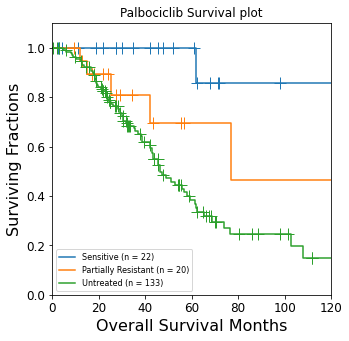

In [34]:
drug = 'Palbociclib'

test_data = pd.read_csv("../data/GENIE/test_428_" + drug + ".txt", sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
    
genie_drug_data = genie_data.query("Sample_ID in @sample_list")
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']

pos_samples = list(genie_drug_data['Sample_ID'])
genie_non_drug_data = genie_data.query("Sample_ID not in @pos_samples").copy()
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['AKT_Inhibitor_Overall'] == 'No']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['HER2_Status'] != 'Positive']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['ER_PR_Receptor_Change'] != 'ER- & PR-']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['Number_of_Endocrine_Therapies_received_in_Metastatic_Treatment'] > 0]
print('Sample size:', len(genie_non_drug_data))
genie_non_drug_data.reset_index(drop=True, inplace=True)

genie_drug_data = genie_drug_data[genie_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['AKT_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['HER2_Status'] != 'Positive']
genie_drug_data = genie_drug_data[genie_drug_data['ER_PR_Receptor_Change'] != 'ER- & PR-']
genie_drug_data = genie_drug_data[genie_drug_data['Number_of_Endocrine_Therapies_received_in_Metastatic_Treatment'] > 0]
print('Sample size:', len(genie_drug_data))
genie_drug_data.reset_index(drop=True, inplace=True)

_, km_fig_palbo_all = genie_analysis_majority_all(test_data, genie_drug_data, genie_non_drug_data, drug, fraction=0.5, resp_th=5)

In [35]:
km_fig_palbo_all.savefig('../plots/figure6/survival_' + drug + '_April_15.svg')

In [ ]:
drug = 'Palbociclib'

test_data = pd.read_csv("../data/GENIE/test_428_" + drug + ".txt", sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
    
genie_drug_data = genie_data.query("Sample_ID in @sample_list")
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']
genie_drug_data = genie_drug_data[genie_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['AKT_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['HER2_Status'] != 'Positive']
genie_drug_data = genie_drug_data[genie_drug_data['ER_PR_Receptor_Change'] != 'ER- & PR-']
genie_drug_data = genie_drug_data[genie_drug_data['Number_of_Endocrine_Therapies_received_in_Metastatic_Treatment'] > 0]
print('Sample size:', len(genie_drug_data))
genie_drug_data.reset_index(drop=True, inplace=True)

p1, p2, km_fig_palbo_3 = genie_analysis_majority_3(test_data, genie_drug_data, drug, fraction=0.5, resp_th=5)

print('Part res', p1)
print('Strong res', p2)

In [ ]:
km_fig_palbo_3.savefig('../plots/figure6/survival_' + drug + '_3_curves_April_04.svg')

In [ ]:
drug = 'Palbociclib'

test_data = pd.read_csv("../data/GENIE/test_428_" + drug + ".txt", sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
    
genie_drug_data = genie_data.query("Sample_ID in @sample_list")
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']

pos_samples = list(genie_drug_data['Sample_ID'])
genie_non_drug_data = genie_data.query("Sample_ID not in @pos_samples").copy()
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['AKT_Inhibitor_Overall'] == 'No']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['HER2_Status'] != 'Positive']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['ER_PR_Receptor_Change'] != 'ER- & PR-']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['Number_of_Endocrine_Therapies_received_in_Metastatic_Treatment'] > 0]
print('Sample size:', len(genie_non_drug_data))
genie_non_drug_data.reset_index(drop=True, inplace=True)

survival_df, km_fig_non_palbo = genie_analysis_majority(test_data, genie_non_drug_data, drug, fraction=0.5, resp_th=5)

In [ ]:
km_fig_non_palbo.savefig('../plots/figure6/survival_non_' + drug + '_April_09.svg')

In [ ]:
drug = 'Palbociclib'

test_data = pd.read_csv("../data/GENIE/test_428_" + drug + ".txt", sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
    
genie_drug_data = genie_data.query("Sample_ID in @sample_list")
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']

pos_samples = list(genie_drug_data['Sample_ID'])
genie_non_drug_data = genie_data.query("Sample_ID not in @pos_samples").copy()
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['AKT_Inhibitor_Overall'] == 'No']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['HER2_Status'] != 'Positive']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['ER_PR_Receptor_Change'] != 'ER- & PR-']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['Number_of_Endocrine_Therapies_received_in_Metastatic_Treatment'] > 0]
print('Sample size:', len(genie_non_drug_data))
genie_non_drug_data.reset_index(drop=True, inplace=True)

p_val_part, p_val_strong, km_fig_non_palbo_3 = genie_analysis_majority_3(test_data, genie_non_drug_data, drug, fraction=0.5, resp_th=5)

print('Part res', p_val_part)
print('Strong res', p_val_strong)

In [ ]:
km_fig_non_palbo_3.savefig('../plots/figure6/survival_non_' + drug + '_3_curves_April_04.svg')

In [ ]:
drug = 'Palbociclib'

test_data = pd.read_csv("../data/GENIE/test_428_" + drug + ".txt", sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
    
genie_drug_data = genie_data.query("Sample_ID in @sample_list")
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']
genie_drug_data = genie_drug_data[genie_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['AKT_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['HER2_Status'] != 'Positive']
genie_drug_data = genie_drug_data[genie_drug_data['ER_PR_Receptor_Change'] != 'ER- & PR-']
genie_drug_data = genie_drug_data[genie_drug_data['Number_of_Endocrine_Therapies_received_in_Metastatic_Treatment'] > 0]
print('Sample size:', len(genie_drug_data))
genie_drug_data.reset_index(drop=True, inplace=True)

genie_analysis(test_data, genie_drug_data, drug, res_type=1, fraction=0.2)

In [ ]:
drug = 'Palbociclib'

test_data = pd.read_csv("../data/GENIE/test_428_" + drug + ".txt", sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
    
genie_drug_data = genie_data.query("Sample_ID in @sample_list")
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']

pos_samples = list(genie_drug_data['Sample_ID'])
genie_non_drug_data = genie_data.query("Sample_ID not in @pos_samples").copy()
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['AKT_Inhibitor_Overall'] == 'No']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['HER2_Status'] != 'Positive']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['ER_PR_Receptor_Change'] != 'ER- & PR-']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['Number_of_Endocrine_Therapies_received_in_Metastatic_Treatment'] > 0]
print('Sample size:', len(genie_non_drug_data))
genie_non_drug_data.reset_index(drop=True, inplace=True)

genie_analysis(test_data, genie_non_drug_data, drug, res_type=1, fraction=0.16)

In [ ]:
drug = 'Palbociclib'

test_data = pd.read_csv("../data/GENIE/test_428_" + drug + ".txt", sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
    
genie_drug_data = genie_data.query("Sample_ID in @sample_list")
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']
genie_drug_data = genie_drug_data[genie_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['AKT_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['HER2_Status'] != 'Positive']
genie_drug_data = genie_drug_data[genie_drug_data['ER_PR_Receptor_Change'] != 'ER- & PR-']
genie_drug_data = genie_drug_data[genie_drug_data['Number_of_Endocrine_Therapies_received_in_Metastatic_Treatment'] > 0]
print('Sample size:', len(genie_drug_data))
genie_drug_data.reset_index(drop=True, inplace=True)

genie_analysis_3sets(test_data, genie_drug_data, drug)

Sample size: 133
Sample size: 73
Treated 0.5179631379630736
Treated Res vs Untreated 0.3836764793527948
Median Survival (Sensitive): inf
Median Survival (Resistant): 76.9
Median Survival (Untreated): 46.4


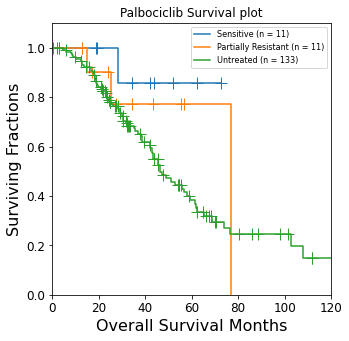

Treated 0.7615553310629142
Treated Res vs Untreated 0.4186252275900243
Median Survival (Sensitive): inf
Median Survival (Resistant): 76.9
Median Survival (Untreated): 46.4


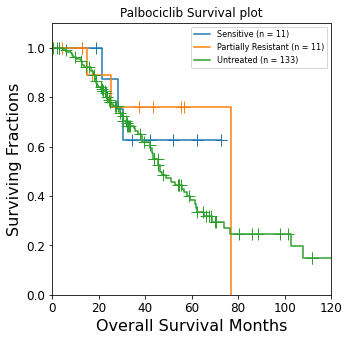

Treated 0.051310382758846376
Treated Res vs Untreated 0.811773929749361
Median Survival (Sensitive): inf
Median Survival (Resistant): 76.9
Median Survival (Untreated): 46.4


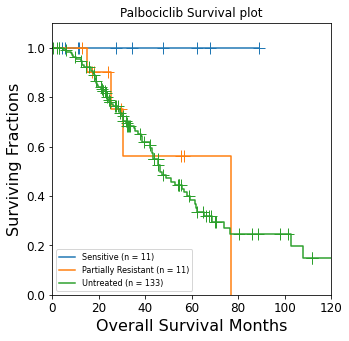

Treated 0.01627999895531802
Treated Res vs Untreated 0.8198621409558218
Median Survival (Sensitive): inf
Median Survival (Resistant): 76.9
Median Survival (Untreated): 46.4


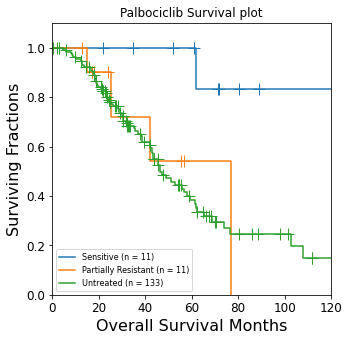

Treated 0.9902833788364688
Treated Res vs Untreated 0.44107402810451823
Median Survival (Sensitive): inf
Median Survival (Resistant): 76.9
Median Survival (Untreated): 46.4


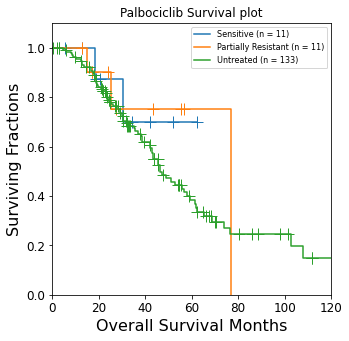

In [51]:
drug = 'Palbociclib'

test_data = pd.read_csv("../data/GENIE/test_428_" + drug + ".txt", sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
    
genie_drug_data = genie_data.query("Sample_ID in @sample_list")
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']

pos_samples = list(genie_drug_data['Sample_ID'])
genie_non_drug_data = genie_data.query("Sample_ID not in @pos_samples").copy()
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['AKT_Inhibitor_Overall'] == 'No']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['HER2_Status'] != 'Positive']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['ER_PR_Receptor_Change'] != 'ER- & PR-']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['Number_of_Endocrine_Therapies_received_in_Metastatic_Treatment'] > 0]
print('Sample size:', len(genie_non_drug_data))
genie_non_drug_data.reset_index(drop=True, inplace=True)

genie_drug_data = genie_drug_data[genie_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['AKT_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['HER2_Status'] != 'Positive']
genie_drug_data = genie_drug_data[genie_drug_data['ER_PR_Receptor_Change'] != 'ER- & PR-']
genie_drug_data = genie_drug_data[genie_drug_data['Number_of_Endocrine_Therapies_received_in_Metastatic_Treatment'] > 0]
print('Sample size:', len(genie_drug_data))
genie_drug_data.reset_index(drop=True, inplace=True)

genie_analysis_all(test_data, genie_drug_data, genie_non_drug_data, drug, res_type=1, fraction=0.16)

In [ ]:
drug = 'Palbociclib'

test_data = pd.read_csv("../data/GENIE/test_428_" + drug + ".txt", sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
    
genie_drug_data = genie_data.query("Sample_ID in @sample_list")
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']

pos_samples = list(genie_drug_data['Sample_ID'])
genie_non_drug_data = genie_data.query("Sample_ID not in @pos_samples").copy()
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['AKT_Inhibitor_Overall'] == 'No']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['HER2_Status'] != 'Positive']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['ER_PR_Receptor_Change'] != 'ER- & PR-']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['Number_of_Endocrine_Therapies_received_in_Metastatic_Treatment'] > 0]
print('Sample size:', len(genie_non_drug_data))
genie_non_drug_data.reset_index(drop=True, inplace=True)

genie_drug_data = genie_drug_data[genie_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['AKT_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['HER2_Status'] != 'Positive']
genie_drug_data = genie_drug_data[genie_drug_data['ER_PR_Receptor_Change'] != 'ER- & PR-']
genie_drug_data = genie_drug_data[genie_drug_data['Number_of_Endocrine_Therapies_received_in_Metastatic_Treatment'] > 0]
print('Sample size:', len(genie_drug_data))
genie_drug_data.reset_index(drop=True, inplace=True)

genie_analysis_4sets(test_data, genie_drug_data, genie_non_drug_data, drug)

In [ ]:
cl_rlipp_df = pd.read_csv('../models/rlipp/' + drug + '_all_pval.txt', sep='\t')[['Term', 'Name', 'P_rho_mean']]
genie_rlipp_df = pd.read_csv('../models/rlipp/' + drug + '_all_pval_genie_428.txt', sep='\t')[['Term', 'Name', 'P_rho_mean']]

merged_df = pd.merge(cl_rlipp_df, genie_rlipp_df, on=['Term', 'Name'], suffixes=('_cl', '_genie'))
merged_df.fillna(0, inplace=True)

merged_df['hue'] = ''
for i, row in merged_df.iterrows():
    genie = row['P_rho_mean_genie']
    cl = row['P_rho_mean_cl']
    if genie < 0.4 and cl < 0.4:
        merged_df.at[i, 'hue'] = 'none'
    elif genie/cl >= 0.66 and genie/cl <= 1.5:
        merged_df.at[i, 'hue'] = 'genie_cell'
    elif genie/cl < 0.66:
        merged_df.at[i, 'hue'] = 'cell'
    elif genie/cl > 1.5:
        merged_df.at[i, 'hue'] = 'genie'

scatterplot_sys = create_scatter_plot_systems(merged_df['P_rho_mean_genie'], merged_df['P_rho_mean_cl'], merged_df['hue'],
                                      'System Importance\n(Clinical samples)', 'System Importance\n(Cell lines)')
print('Spearman rho:', stats.spearmanr(merged_df['P_rho_mean_cl'], merged_df['P_rho_mean_genie'])[0])

In [ ]:
scatterplot_sys.savefig('../plots/figure6/scatterplot_system_importance_hue_all_March_29.svg')

In [ ]:
cdk_pos = 0
cdk_neg = 0
for _,row in cl_rlipp_df.iterrows():
    #if row['P_rho_mean'] < 0.5:
    #    continue
    if 'CDK4' in term_all_genes[row['Term']] or 'CDK6' in term_all_genes[row['Term']]:
        print(row['Name'])
        cdk_pos += 1
    else:
        cdk_neg += 1

print(cdk_pos, cdk_neg)

In [ ]:
drug = 'Palbociclib'
fold_size = 5

for i in range(1, fold_size+1):
    create_gene_rho(drug, gene_list, '')
    create_gene_rho(drug, gene_list, '_genie_428')

In [ ]:
aggregate_gene_rho(drug, gene_list, '')
aggregate_gene_rho(drug, gene_list, '_genie_428')

In [ ]:
cell_gene_rho_df = pd.read_csv('../models/rlipp/' + drug + '_all_gene_rho.txt', sep='\t')[['Gene', 'Rho']]
genie_gene_rho_df = pd.read_csv('../models/rlipp/' + drug + '_all_gene_rho_genie_428.txt', sep='\t')[['Gene', 'Rho']]

merged_gene_rho_df = pd.merge(cell_gene_rho_df, genie_gene_rho_df, on=['Gene'], suffixes=('_cl', '_genie'))
merged_gene_rho_df.dropna(inplace=True)
scatterplot_gene_rho = create_scatter_plot_genes(merged_gene_rho_df['Rho_genie'], merged_gene_rho_df['Rho_cl'],
                                         'Gene Importance\n(Clinical samples)', 'Gene Importance\n(Cell lines)')
print('Spearman rho:', stats.spearmanr(merged_gene_rho_df['Rho_genie'], merged_gene_rho_df['Rho_cl'])[0])

In [ ]:
scatterplot_gene_rho.savefig('../plots/figure6/scatterplot_gene_rho_March_28.svg')

0.009207366233084073


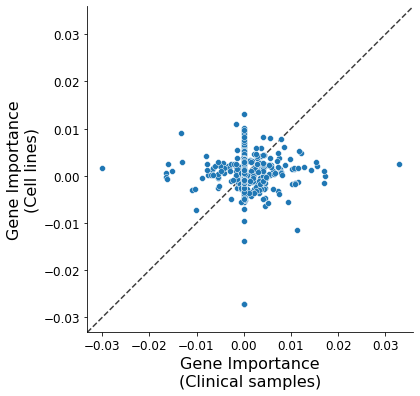

In [59]:
mutations = pd.read_csv('../data/training_files_av/cell2mutation_ctg_av.txt', header=None, names=gene_list)
cn_deletions = pd.read_csv('../data/training_files_av/cell2cndeletion_ctg_av.txt', header=None, names=gene_list)
cn_amplifications = pd.read_csv('../data/training_files_av/cell2cnamplification_ctg_av.txt', header=None, names=gene_list)
#cell_features = np.array(mutations | cn_deletions | cn_amplifications)
cell_features = np.array(cn_deletions)

mutations = pd.read_csv('../data/GENIE/cell2mutation_428.txt', header=None, names=gene_list)
cn_deletions = pd.read_csv('../data/GENIE/cell2cndeletion_428.txt', header=None, names=gene_list)
cn_amplifications = pd.read_csv('../data/GENIE/cell2cnamplification_428.txt', header=None, names=gene_list)
#genie_features = np.array(mutations | cn_deletions | cn_amplifications)
genie_features = np.array(cn_deletions)

gene_sp = gene_importance(drug, cell_features, genie_features, gene_list, fold_size=5)

In [60]:
gene_sp.savefig('../plots/figure6/scatterplot_gene_importance_cn_deletions_April_16.svg')

In [ ]:
system_names = ['NEST:132', 'NEST:85', 'NEST:17']

drug = 'Palbociclib'

for s in system_names:

    test_data = pd.read_csv("../data/GENIE/test_428_" + drug + ".txt", sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])

    genie_drug_data = genie_data.query("Sample_ID in @sample_list")
    genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']
    genie_drug_data = genie_drug_data[genie_drug_data['mTOR_Inhibitor_Overall'] == 'No']
    genie_drug_data = genie_drug_data[genie_drug_data['AKT_Inhibitor_Overall'] == 'No']
    genie_drug_data = genie_drug_data[genie_drug_data['HER2_Status'] != 'Positive']
    genie_drug_data = genie_drug_data[genie_drug_data['ER_PR_Receptor_Change'] != 'ER- & PR-']
    genie_drug_data.reset_index(drop=True, inplace=True)

    p_val, km_fig_sys = genie_analysis_system(s, test_data, genie_drug_data, drug, resp_th=5)
    print(s, p_val)
    #km_fig_sys.savefig('../plots/figure6/survival_' + s + '.svg')

In [ ]:
system_names = ['NEST:132', 'NEST:85', 'NEST:17']

drug = 'Palbociclib'

for s in system_names:

    test_data = pd.read_csv("../data/GENIE/test_428_" + drug + ".txt", sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])

    genie_drug_data = genie_data.query("Sample_ID in @sample_list")
    genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']
    genie_drug_data = genie_drug_data[genie_drug_data['mTOR_Inhibitor_Overall'] == 'No']
    genie_drug_data = genie_drug_data[genie_drug_data['AKT_Inhibitor_Overall'] == 'No']

    pos_samples = list(genie_drug_data['Sample_ID'])
    genie_non_drug_data = genie_data.query("Sample_ID not in @pos_samples").copy()
    genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['HER2_Status'] != 'Positive']
    genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['ER_PR_Receptor_Change'] != 'ER- & PR-']
    genie_non_drug_data.reset_index(drop=True, inplace=True)
    
    p_val, km_fig_sys = genie_analysis_system(s, test_data, genie_non_drug_data, drug, resp_th=5)
    print(s, p_val)
    #km_fig_sys.savefig('../plots/figure6/survival_' + s + '.svg')

In [ ]:
#nest132_genes = ['TP53', 'MYC', 'RB1', 'EGFR', 'FRS2', 'ERBB3', 'ERBB4', 'FGF7', 'EGF', 'IGF2', 'FGF2', 'FGF5', 'FGF1', 'IGF1']
nest132_genes = ['RB1', 'EGFR', 'ERBB4']

drug = 'Palbociclib'

test_data = pd.read_csv("../data/GENIE/test_428_" + drug + ".txt", sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])

genie_drug_data = genie_data.query("Sample_ID in @sample_list")
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']
genie_drug_data = genie_drug_data[genie_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['AKT_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['HER2_Status'] != 'Positive']
genie_drug_data = genie_drug_data[genie_drug_data['ER_PR_Receptor_Change'] != 'ER- & PR-']
genie_drug_data.reset_index(drop=True, inplace=True)

pval, fig = genie_analysis_gene_embeddings(nest132_genes, test_data, genie_drug_data, drug, resp_th=5)

print("{}\t{:.4f}".format('132 genes', pval))

In [ ]:
drug = 'Palbociclib'

test_data = pd.read_csv("../data/GENIE/test_428_" + drug + ".txt", sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
    
genie_drug_data = genie_data.query("Sample_ID in @sample_list")
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']
genie_drug_data = genie_drug_data[genie_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['AKT_Inhibitor_Overall'] == 'No']

pos_samples = list(genie_drug_data['Sample_ID'])
genie_non_drug_data = genie_data.query("Sample_ID not in @pos_samples").copy()
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['HER2_Status'] != 'Positive']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['ER_PR_Receptor_Change'] != 'ER- & PR-']
genie_non_drug_data.reset_index(drop=True, inplace=True)

pval, fig = genie_analysis_gene_embeddings(nest132_genes, test_data, genie_non_drug_data, drug, resp_th=5)
    
print("{}\t{:.4f}".format('132 genes', pval))

In [ ]:
nest85_genes = ['CREBBP', 'EP300', 'AR']

drug = 'Palbociclib'

test_data = pd.read_csv("../data/GENIE/test_428_" + drug + ".txt", sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])

genie_drug_data = genie_data.query("Sample_ID in @sample_list")
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']
genie_drug_data = genie_drug_data[genie_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['AKT_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['HER2_Status'] != 'Positive']
genie_drug_data = genie_drug_data[genie_drug_data['ER_PR_Receptor_Change'] != 'ER- & PR-']
genie_drug_data.reset_index(drop=True, inplace=True)

pval, fig = genie_analysis_gene_embeddings(nest85_genes, test_data, genie_drug_data, drug, resp_th=5)

print("{}\t{:.4f}".format('85 genes', pval))

In [ ]:
nest85_genes = ['CREBBP', 'EP300', 'AR']

drug = 'Palbociclib'

test_data = pd.read_csv("../data/GENIE/test_428_" + drug + ".txt", sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
    
genie_drug_data = genie_data.query("Sample_ID in @sample_list")
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']
genie_drug_data = genie_drug_data[genie_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['AKT_Inhibitor_Overall'] == 'No']

pos_samples = list(genie_drug_data['Sample_ID'])
genie_non_drug_data = genie_data.query("Sample_ID not in @pos_samples").copy()
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['HER2_Status'] != 'Positive']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['ER_PR_Receptor_Change'] != 'ER- & PR-']
genie_non_drug_data.reset_index(drop=True, inplace=True)

pval, fig = genie_analysis_gene_embeddings(nest85_genes, test_data, genie_non_drug_data, drug, resp_th=5)
    
print("{}\t{:.4f}".format('85 genes', pval))

In [ ]:
#132 Resistant

drug = 'Palbociclib'
title = 'RB1'
gene_feature_map = {'RB1':['m','d']}
#gene_feature_map = {'RB1':['m','d'], 'EGFR':['m','a'], 'ERBB4':['d']}

gene_alterations = np.zeros(len(sample_map), dtype=int)
for g, feature_list in gene_feature_map.items():
    for f in feature_list:
        if f == 'm':
            mutations = np.array(pd.read_csv('../data/GENIE/cell2mutation_428.txt', header=None, names=gene_list)[g])
            print(g, f, np.count_nonzero(mutations))
            gene_alterations |= mutations
        elif f == 'a':
            amplifications = np.array(pd.read_csv('../data/GENIE/cell2cnamplification_428.txt', header=None, names=gene_list)[g])
            print(g, f, np.count_nonzero(amplifications))
            gene_alterations |= amplifications
        else:
            deletions = np.array(pd.read_csv('../data/GENIE/cell2cndeletion_428.txt', header=None, names=gene_list)[g])
            print(g, f, np.count_nonzero(deletions))
            gene_alterations |= deletions
            
print(np.count_nonzero(gene_alterations))

test_data = pd.read_csv("../data/GENIE/test_428_" + drug + ".txt", sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
    
genie_drug_data = genie_data.query("Sample_ID in @sample_list")
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']
genie_drug_data = genie_drug_data[genie_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['AKT_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['HER2_Status'] != 'Positive']
genie_drug_data = genie_drug_data[genie_drug_data['ER_PR_Receptor_Change'] != 'ER- & PR-']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['Number_of_Endocrine_Therapies_received_in_Metastatic_Treatment'] > 0]
genie_drug_data.reset_index(drop=True, inplace=True)

survival_df, km_fig_rb1 = genie_analysis_gene_alterations(gene_alterations, sample_map, genie_drug_data, title, is_resistant=True)

In [ ]:
km_fig_rb1.savefig('../plots/figure6/survival_' + title + '_April_09.svg')

In [ ]:
#132 Resistant

drug = 'Palbociclib'
title = 'CCND1'
gene_feature_map = {'CCND1':['a']}

gene_alterations = np.zeros(len(sample_map), dtype=int)
for g, feature_list in gene_feature_map.items():
    for f in feature_list:
        if f == 'm':
            mutations = np.array(pd.read_csv('../data/GENIE/cell2mutation_428.txt', header=None, names=gene_list)[g])
            print(g, f, np.count_nonzero(mutations))
            gene_alterations |= mutations
        elif f == 'a':
            amplifications = np.array(pd.read_csv('../data/GENIE/cell2cnamplification_428.txt', header=None, names=gene_list)[g])
            print(g, f, np.count_nonzero(amplifications))
            gene_alterations |= amplifications
        else:
            deletions = np.array(pd.read_csv('../data/GENIE/cell2cndeletion_428.txt', header=None, names=gene_list)[g])
            print(g, f, np.count_nonzero(deletions))
            gene_alterations |= deletions
            
print(np.count_nonzero(gene_alterations))

test_data = pd.read_csv("../data/GENIE/test_428_" + drug + ".txt", sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
    
genie_drug_data = genie_data.query("Sample_ID in @sample_list")
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']
genie_drug_data = genie_drug_data[genie_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['AKT_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['HER2_Status'] != 'Positive']
genie_drug_data = genie_drug_data[genie_drug_data['ER_PR_Receptor_Change'] != 'ER- & PR-']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['Number_of_Endocrine_Therapies_received_in_Metastatic_Treatment'] > 0]
genie_drug_data.reset_index(drop=True, inplace=True)

survival_df, km_fig_ccnd1 = genie_analysis_gene_alterations(gene_alterations, sample_map, genie_drug_data, title, is_resistant=False)

In [ ]:
km_fig_ccnd1.savefig('../plots/figure6/survival_' + title + '_April_09.svg')

In [ ]:
#132 Resistant

drug = 'Palbociclib'
title = 'CCNE1'
gene_feature_map = {'CCNE1':['a']}

gene_alterations = np.zeros(len(sample_map), dtype=int)
for g, feature_list in gene_feature_map.items():
    for f in feature_list:
        if f == 'm':
            mutations = np.array(pd.read_csv('../data/GENIE/cell2mutation_428.txt', header=None, names=gene_list)[g])
            print(g, f, np.count_nonzero(mutations))
            gene_alterations |= mutations
        elif f == 'a':
            amplifications = np.array(pd.read_csv('../data/GENIE/cell2cnamplification_428.txt', header=None, names=gene_list)[g])
            print(g, f, np.count_nonzero(amplifications))
            gene_alterations |= amplifications
        else:
            deletions = np.array(pd.read_csv('../data/GENIE/cell2cndeletion_428.txt', header=None, names=gene_list)[g])
            print(g, f, np.count_nonzero(deletions))
            gene_alterations |= deletions
            
print(np.count_nonzero(gene_alterations))

test_data = pd.read_csv("../data/GENIE/test_428_" + drug + ".txt", sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
    
genie_drug_data = genie_data.query("Sample_ID in @sample_list")
genie_drug_data = genie_drug_data[genie_drug_data[func_map[drug]] == 'Yes']
genie_drug_data = genie_drug_data[genie_drug_data['mTOR_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['AKT_Inhibitor_Overall'] == 'No']
genie_drug_data = genie_drug_data[genie_drug_data['HER2_Status'] != 'Positive']
genie_drug_data = genie_drug_data[genie_drug_data['ER_PR_Receptor_Change'] != 'ER- & PR-']
genie_non_drug_data = genie_non_drug_data[genie_non_drug_data['Number_of_Endocrine_Therapies_received_in_Metastatic_Treatment'] > 0]
genie_drug_data.reset_index(drop=True, inplace=True)

survival_df, km_fig_ccne1 = genie_analysis_gene_alterations(gene_alterations, sample_map, genie_drug_data, title, is_resistant=False)

In [ ]:
km_fig_ccne1.savefig('../plots/figure6/survival_' + title + '_April_09.svg')

In [ ]:
print(genie_drug_data.columns)